# Bulk Deconvolution Tutorial Notebook

A notebook that features the functionality of the package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# import deconvolution methods
import cellanneal
from scipy.optimize import nnls
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler


# statistical tests
import scipy.stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# stats & plot specific from .py files
from src.plot import Plot
from stats import statsTest
from src.helper import flatten, gene_intersection
import src.project_configs as project_configs
from src.deconv import Deconvolution

from tqdm import tqdm

In [2]:
# plot parameters all coming from project.configurations
plt.style.use(project_configs.style)
plt.rcParams['font.family'] = project_configs.font_family
plt.rcParams['font.serif'] = project_configs.font_serif
plt.rcParams['font.monospace'] = project_configs.font_monospace
plt.rcParams['font.size'] = project_configs.font_size
plt.rcParams['axes.labelsize'] = project_configs.axes_label_size
plt.rcParams['axes.labelweight'] = project_configs.axes_label_weight
plt.rcParams['axes.titlesize'] = project_configs.axes_title_size
plt.rcParams['xtick.labelsize'] = project_configs.xtick_label_size
plt.rcParams['ytick.labelsize'] = project_configs.ytick_label_size
plt.rcParams['legend.fontsize'] = project_configs.legend_font_size 
plt.rcParams['figure.titlesize'] = project_configs.figure_title_size
plt.rcParams['image.cmap'] = project_configs.image_cmap 
plt.rcParams['image.interpolation'] = project_configs.image_interpolation 
plt.rcParams['figure.figsize'] = project_configs.figure_size
plt.rcParams['axes.grid']=project_configs.axes_grid
plt.rcParams['lines.linewidth'] = project_configs.lines_line_width
plt.rcParams['lines.markersize'] = project_configs.lines_marker_size
cells_p = project_configs.cells_p

Here are some datasets you can play around with

In [3]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
atap_bulk = pd.read_csv('../data/atap.pseudobulk_counts.logcpm.csv',index_col=0)
atap_true = pd.read_csv('../data/atap.scg_proportions.csv',index_col=0) 
cleveland_bulk = pd.read_csv('../data/cleveland.pseudobulk_counts.logcpm.csv',index_col=0)
cleveland_true = pd.read_csv('../data/cleveland.scg_proportions.csv',index_col=0)
lmu_bulk = pd.read_csv('../data/lmu.pseudobulk_counts.logcpm.csv',index_col=0)
lmu_true = pd.read_csv('../data/lmu.scg_proportions.csv',index_col=0)

In [4]:
atap_true_general =pd.DataFrame()          
atap_true_general['Myeloid'] = atap_true['CD209+ moDC'] + atap_true['CD83+ CLEC9A+ DC'] + atap_true['CD83- CLEC9A+ DC']+atap_true['CLEC10A+ DC']+atap_true['IL7R+ Activated DC']+atap_true['LTB+ DC']+atap_true['Mast Cell']+atap_true['Monocyte Inflammatory']+atap_true['Proliferating myeloid']+atap_true['Resident Macrophage']
atap_true_general['T Cell'] = atap_true['CD4 SELL naive'] + atap_true['CD4 TRM'] + atap_true['CD4 Tfh']+atap_true['CD4 Th17']+atap_true['CD4 Tfr'] + atap_true['CD4 Th1']+atap_true['CD4 Tph']+atap_true['CD4 Treg']+atap_true['CD8 Effector']+atap_true['CD8 IEL']+atap_true['CD8 SELL Naive']+atap_true['ILC3']+atap_true['MAIT']+atap_true['NK']+atap_true['Proliferating T cells']+atap_true['gd T cell 1']+atap_true['gd T cell 2']
atap_true_general['B Cell'] = atap_true['GC-like B cell'] + atap_true['Memory B cell'] + atap_true['Naive B cell']+atap_true['Plasma Cell']+atap_true['Plasmablast']
atap_true_general['Stroma'] = atap_true['Arterial Pericyte'] + atap_true['Blood Endothelial Cell'] + atap_true['Fibroblast']+atap_true['Glial Cell']+atap_true['Inflammatory Fibroblast']+atap_true['Lymphatic Endothelial Cell']+atap_true['Myofibroblast']+atap_true['Pericyte']+atap_true['Post-capillary venules']+atap_true['Proliferating Stromal Cell']+atap_true['Smooth Muscle Cell']
atap_true_general['Epithelium'] = atap_true['Enterocyte'] + atap_true['Enteroendocrine Cell'] + atap_true['Epithelial M Cell']+atap_true['Epithelial Progenitor Cell']+atap_true['Epithelial Stem Cell']+atap_true['Goblet Cell']+atap_true['Tuft Cell']

## deconv.py

`deconvolution(signature, training_data):` - Currently only runs cellanneal deconvolution on the provided gene reference and bulk samples provided

some paths to Celsius in house gene references:

- `/mnt/cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv`
- `/mnt/cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments_with_neutrophils.csv`

In [5]:
deconvolution_object = Deconvolution()

In [6]:
# change train to True to run deconvolution module. If not, you can some saved results 
train = False

if train:   
    predicted = deconvolution_object.deconvolution(signature, atap_bulk)
else:
    predicted = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/results3/cellanneal_atap_compartment2.csv",index_col=0)

`benchmark(df_list,true,statistic=?)`- benchmarks multiple deconvolution methods against one dataset.

In this module there is also the statistic (string) parameter where you can choose one statistic to benchmark on (pearson, r2, diff, rmse)

(5, 223)
(5, 223)
(5, 223)
(5, 223)
(5, 223)
(5, 223)
### Here are the results of the methods based on cell specific & benchmarked on residual ###


cellanneal    4
Kassandra     1
Name: winners, dtype: int64


,cellanneal,Kassandra,SVR,winners value,winners
Epithelium,0.001071,0.004280,0.001071,0.001071,cellanneal
T Cell,0.004280,0.001071,0.004280,0.001071,Kassandra
Myeloid,0.010228,0.010228,0.010228,0.010228,cellanneal
Stroma,0.027723,0.027723,0.027723,0.027723,cellanneal
B Cell,0.057408,0.057408,0.057408,0.057408,cellanneal


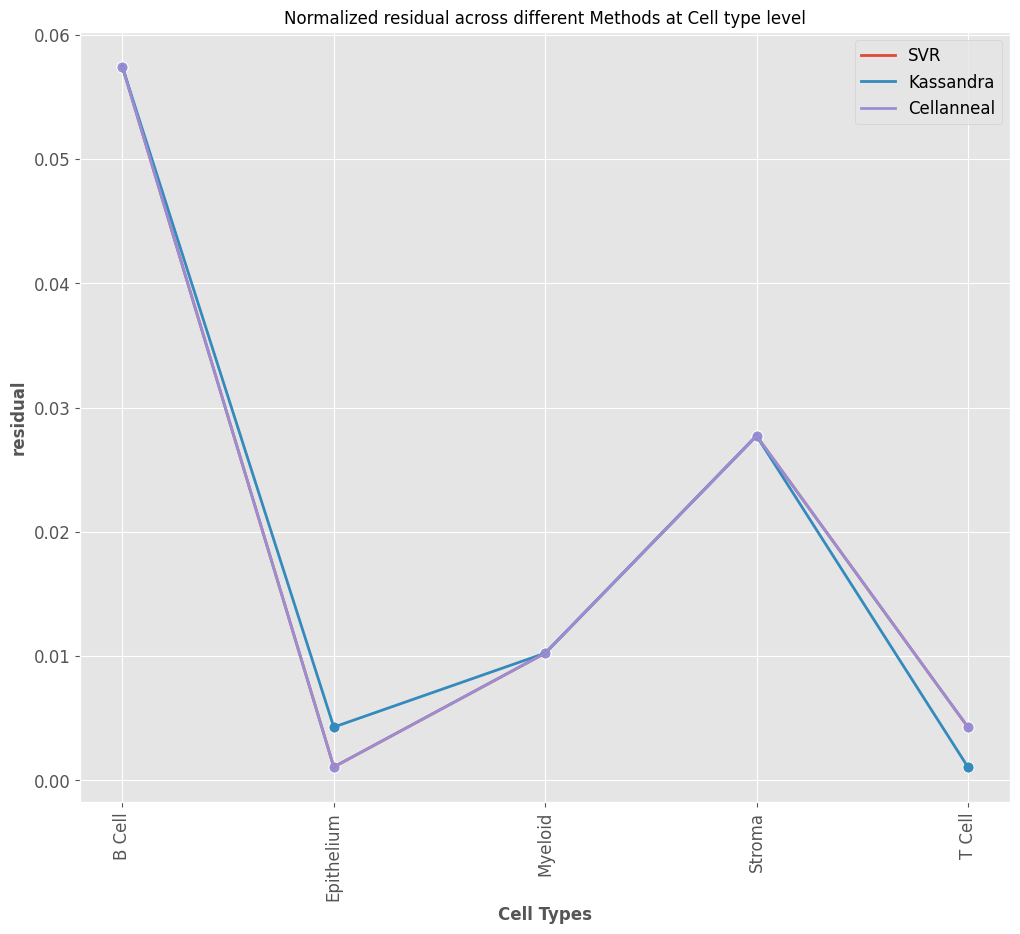

(5, 223)
(5, 223)
(5, 223)
(5, 223)
(5, 223)
(5, 223)
### Here are the results of the methods based on cell specific & benchmarked on rmse ###


SVR           3
cellanneal    2
Name: winners, dtype: int64


,cellanneal,Kassandra,SVR,winners value,winners
Myeloid,0.017362,0.070276,0.011232,0.011232,SVR
B Cell,0.026978,0.035587,0.011993,0.011993,SVR
T Cell,0.089397,0.695732,0.102855,0.089397,cellanneal
Stroma,0.091886,0.812687,0.094669,0.091886,cellanneal
Epithelium,0.149313,0.167695,0.125734,0.125734,SVR


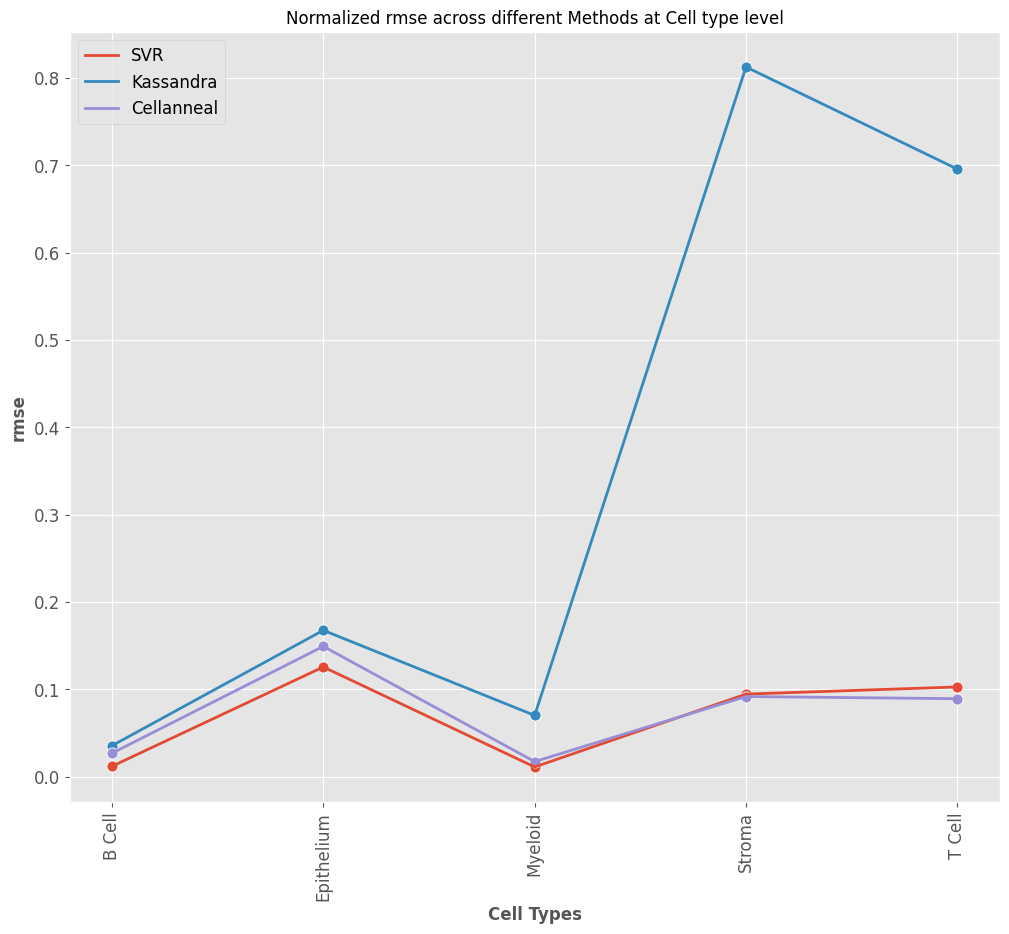

In [7]:
# loading these saved results files for demonstration purposes
cellanneal = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/results3/cellanneal_atap_compartment2.csv",index_col = 0)
svr = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/results3/svr_atap_compartment2.csv",index_col = 0).T   
kass = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/results3/kassandra_atap2.csv",index_col = 0).T
# Kassandra didn't have the same signatures so additional processing of the data is required
kass= kass[["B_cells", "T_cells", "Myeloid_cells"]]
kass = kass.rename(columns={"B_cells": "B Cell", "T_cells": "T Cell", "Myeloid_cells": "Myeloid"})
kass["Stroma"] = 1
kass["Epithelium"] = 1

# benchmark returns 
deconvolution_object.benchmark([cellanneal.T, kass.T, svr.T],atap_true_general.T, statistic = 'residual')
deconvolution_object.benchmark([cellanneal.T, kass.T, svr.T],atap_true_general.T, statistic = 'rmse')

# plot.py

This file contains plotting functions that could be useful to visualize deconolution results and benchmarking utilities

In [8]:
plot_object = Plot()

`stack_plot`: gives us a stack bar plot to visualize the predicted proportion

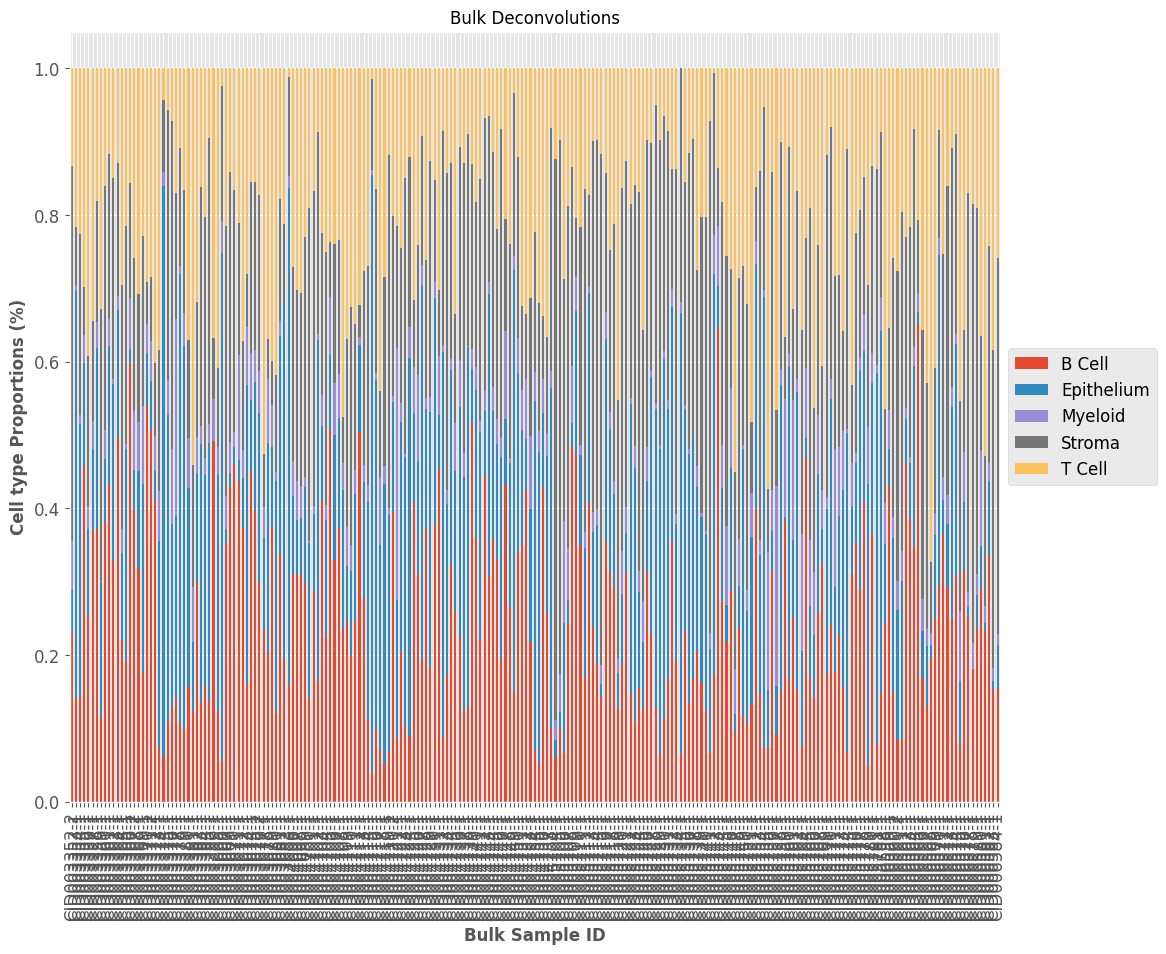

In [9]:
plot_object.stack_plot(predicted)

`heat_map` provides a more quanitfiable measure of showcasing the proportions instead of "guestimating" the relative proportions with the naked eye

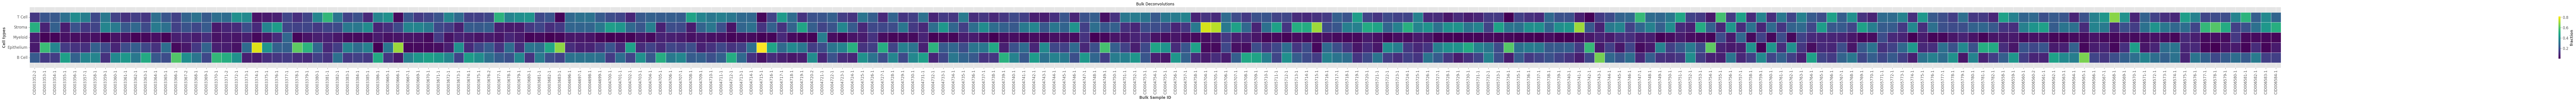

In [10]:
plot_object.heat_map(predicted)

In [11]:
# color pallette
cells_p = {'B Cell': '#558ce0',
            'T Cell': '#28a35c',
            'Myeloid': '#58d3bb',
            'Stroma': '#eaabcc',
            'Epithelium': '#F6783E',
}

`plot_cell` might be the most useful visualization where it takes the Spearman Correlation, P-value and a true vs predicted representation of our deconvolution. Can be generalized to showcase at a compartment and cell type level. Also if you untranspose the dataframes, it will produce the true vs predicted for each individual sample.

array([<Axes: title={'center': 'B Cell, Spearman = 0.803\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <Axes: title={'center': 'Epithelium, Spearman = 0.964\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <Axes: title={'center': 'Myeloid, Spearman = 0.834\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <Axes: title={'center': 'Stroma, Spearman = 0.877\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <Axes: title={'center': 'T Cell, Spearman = 0.793\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

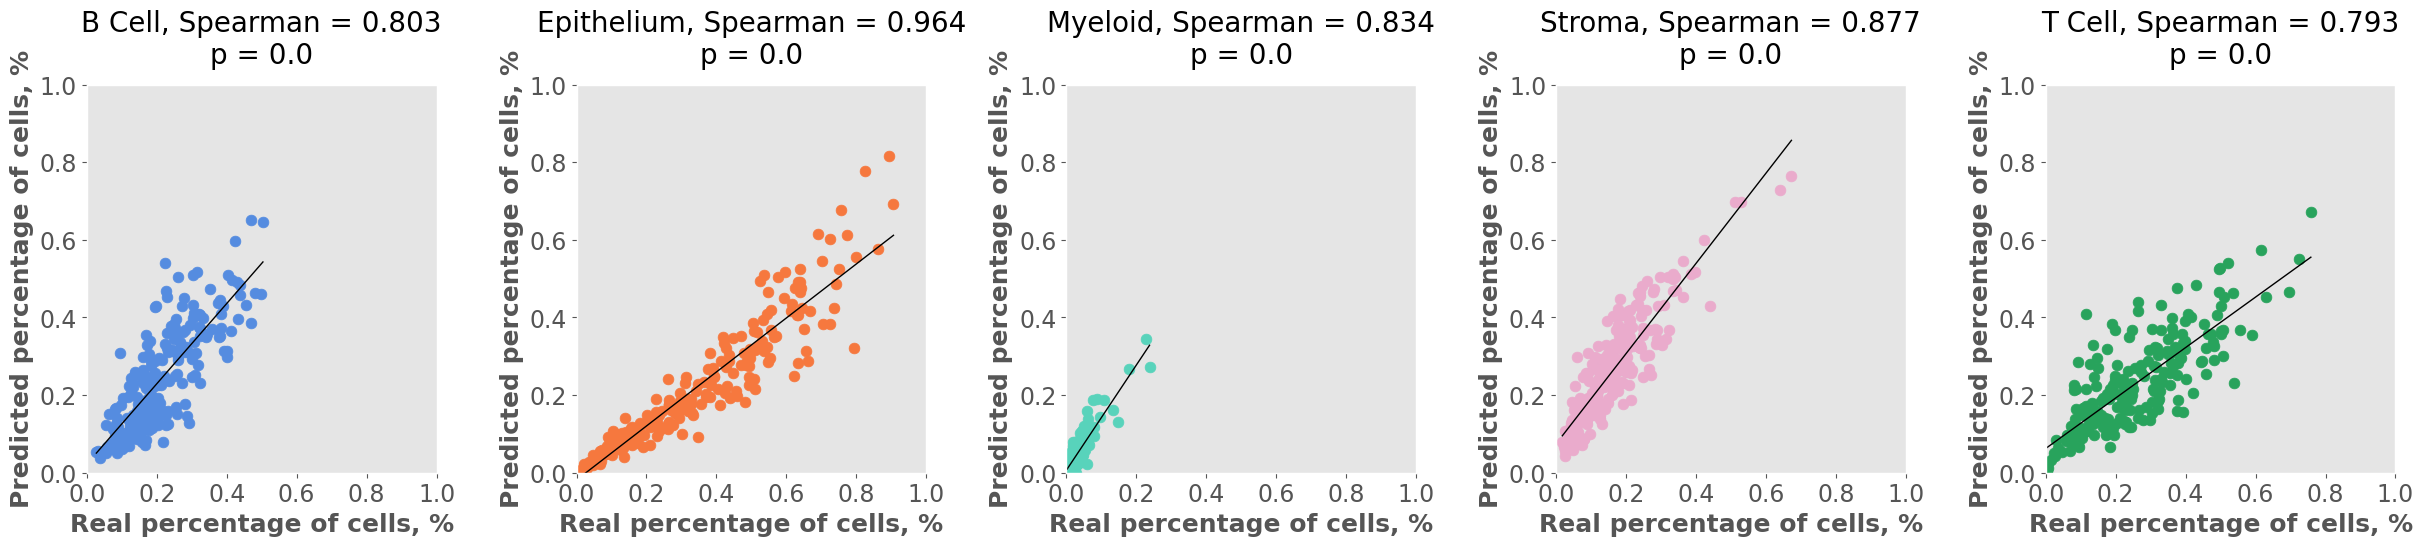

In [12]:
plot_object.plot_cell(predicted.T, atap_true_general.T, pallete=cells_p)

`plot_whole` is the same as plot cell except it is visualized on a singular plot. An additional RMSE and R^2 is calculated.

Statistical Tests
------------------------
RMSE: 0.104 
Pearson Correlation Coefficient: 0.8 
P value: 0.0 
R^2: 0.634


<Axes: xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>

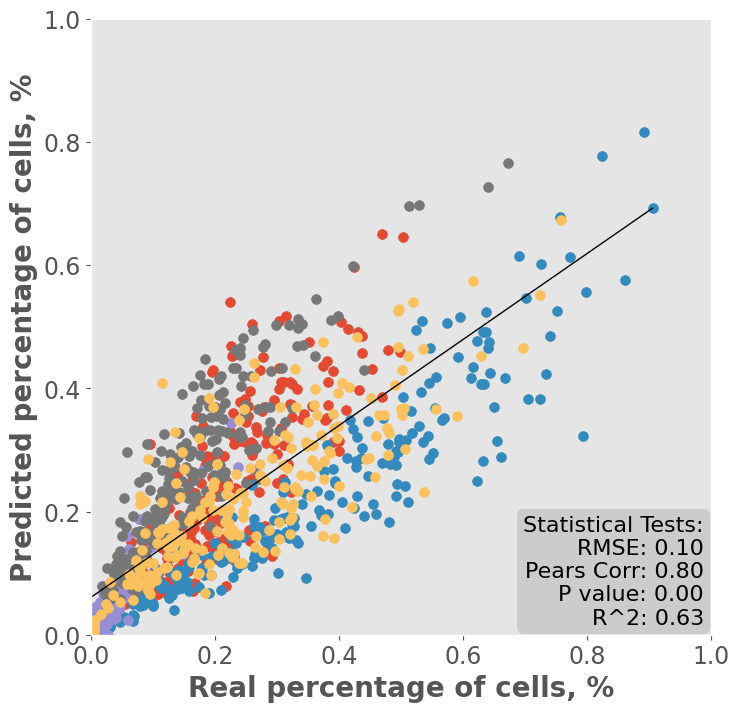

In [13]:
plot_object.plot_whole(predicted, atap_true_general, pallete=cells_p)

`bland_altman` are visualization techniques to showcase residuals, and any relative bias that may occur relative within a compartment

Index(['B Cell', 'Epithelium', 'Myeloid', 'Stroma', 'T Cell'], dtype='object') Index(['CID003352-2', 'CID003353-1', 'CID003354-1', 'CID003355-1',
       'CID003356-1', 'CID003357-1', 'CID003358-1', 'CID003359-1',
       'CID003360-1', 'CID003361-1',
       ...
       'CID006575-1', 'CID006576-1', 'CID006577-1', 'CID006578-1',
       'CID006579-1', 'CID006580-1', 'CID006581-1', 'CID006582-1',
       'CID006583-1', 'CID006584-1'],
      dtype='object', length=223)


array([<Axes: title={'center': 'Bland Altman of B Cell: {-0.052 +/- 0.079}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
       <Axes: title={'center': 'Bland Altman of Epithelium: {-0.124 +/- 0.088}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
       <Axes: title={'center': 'Bland Altman of Myeloid: {0.004 +/- 0.022}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
       <Axes: title={'center': 'Bland Altman of Stroma: {0.056 +/- 0.064}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
       <Axes: title={'center': 'Bland Altman of T Cell: {-0.033 +/- 0.09}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
      dtype=object)

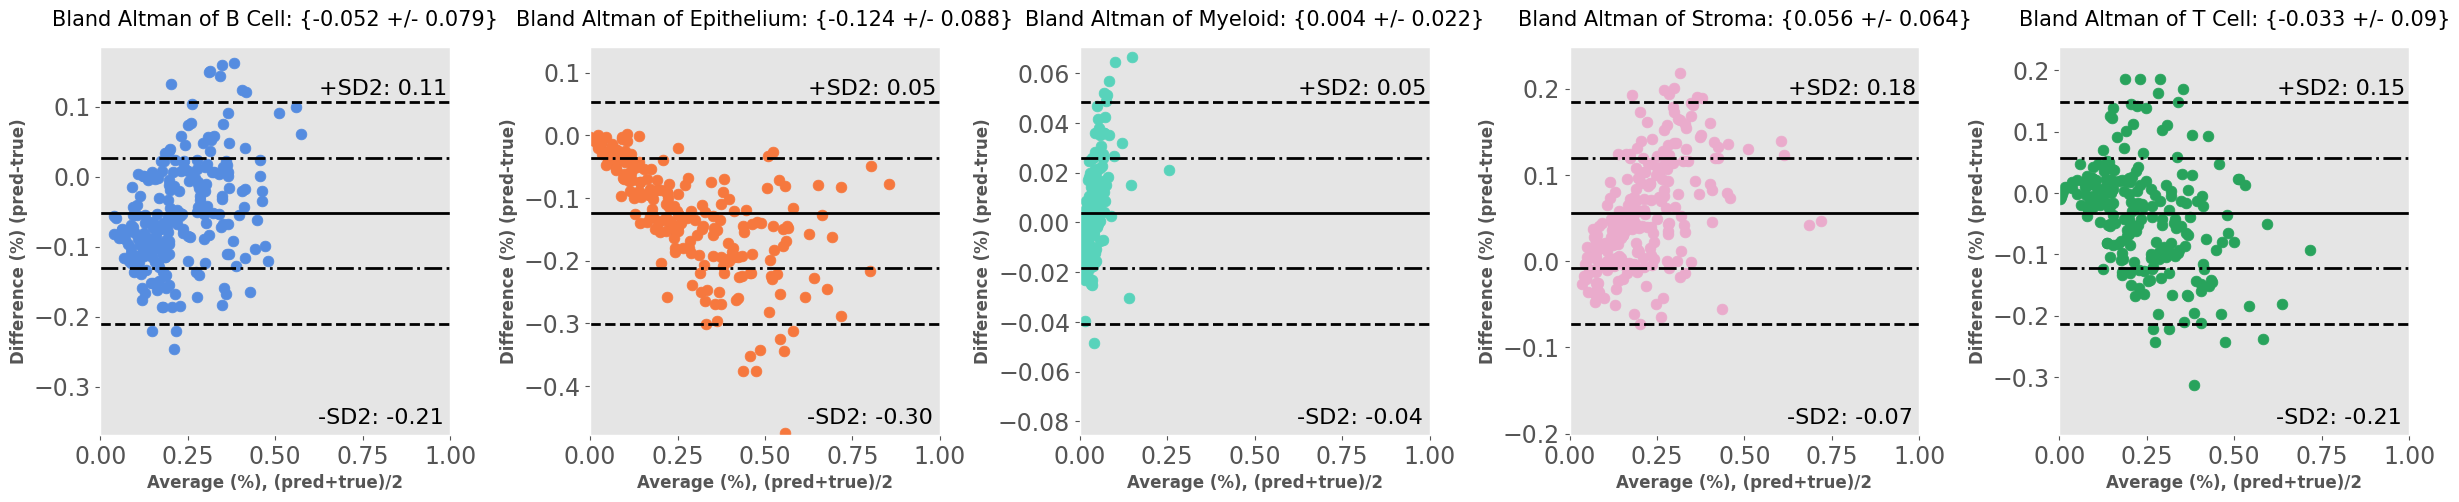

In [14]:
plot_object.bland_altman(predicted.T, atap_true_general.T, pallete=cells_p)

In [16]:
cellanneal_g = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/results3/cellanneal_atap.csv",index_col=0)
svr_g = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/results3/svr_atap.csv",index_col=0)

`nrmse()` is a boxplot of cell type or compartment type normalized RMSE calculated with a min-max normalization technique

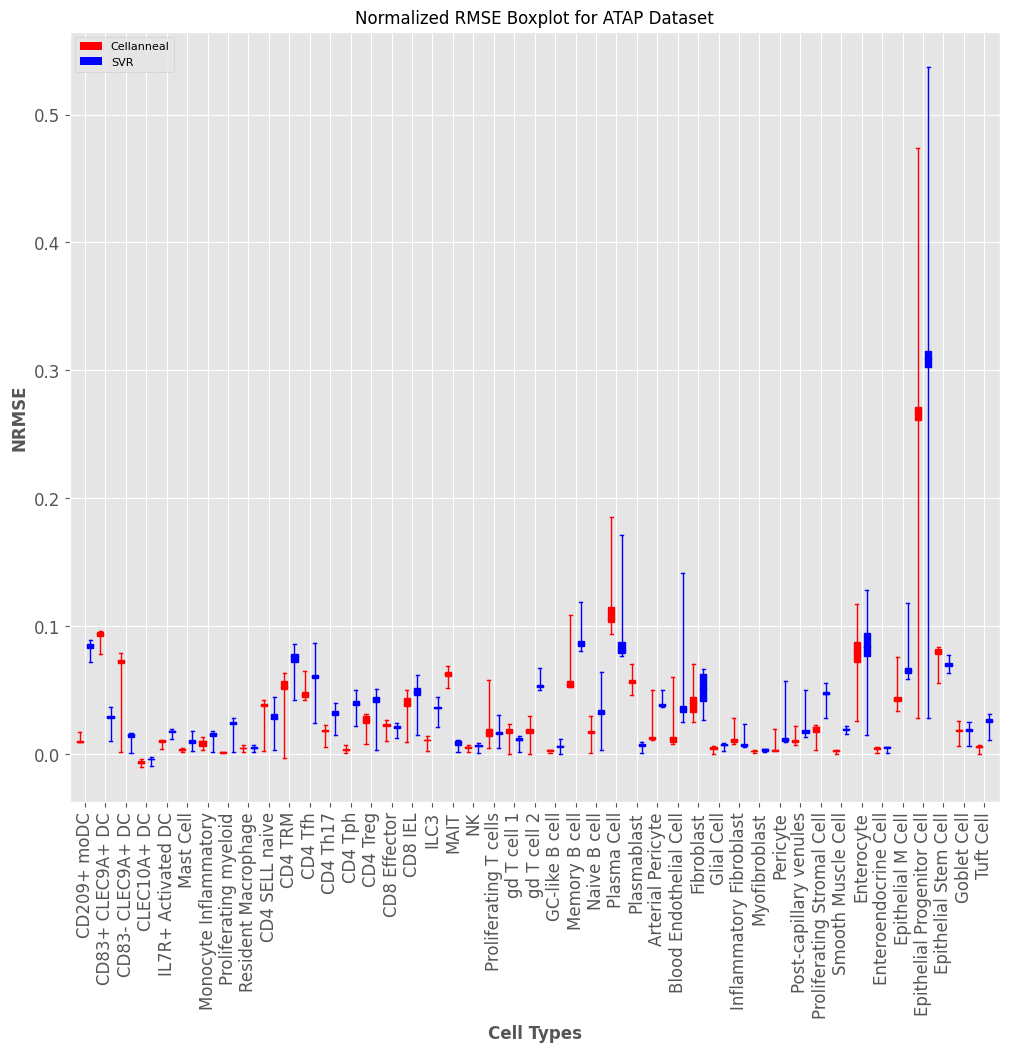

In [17]:
plot_object.nrmse(cellanneal_g,svr_g.T,atap_true)

`nresidual` like nrmse takes the min-max normalization of our residuals to show a relative percentage of our residuals due to varying true measurements.

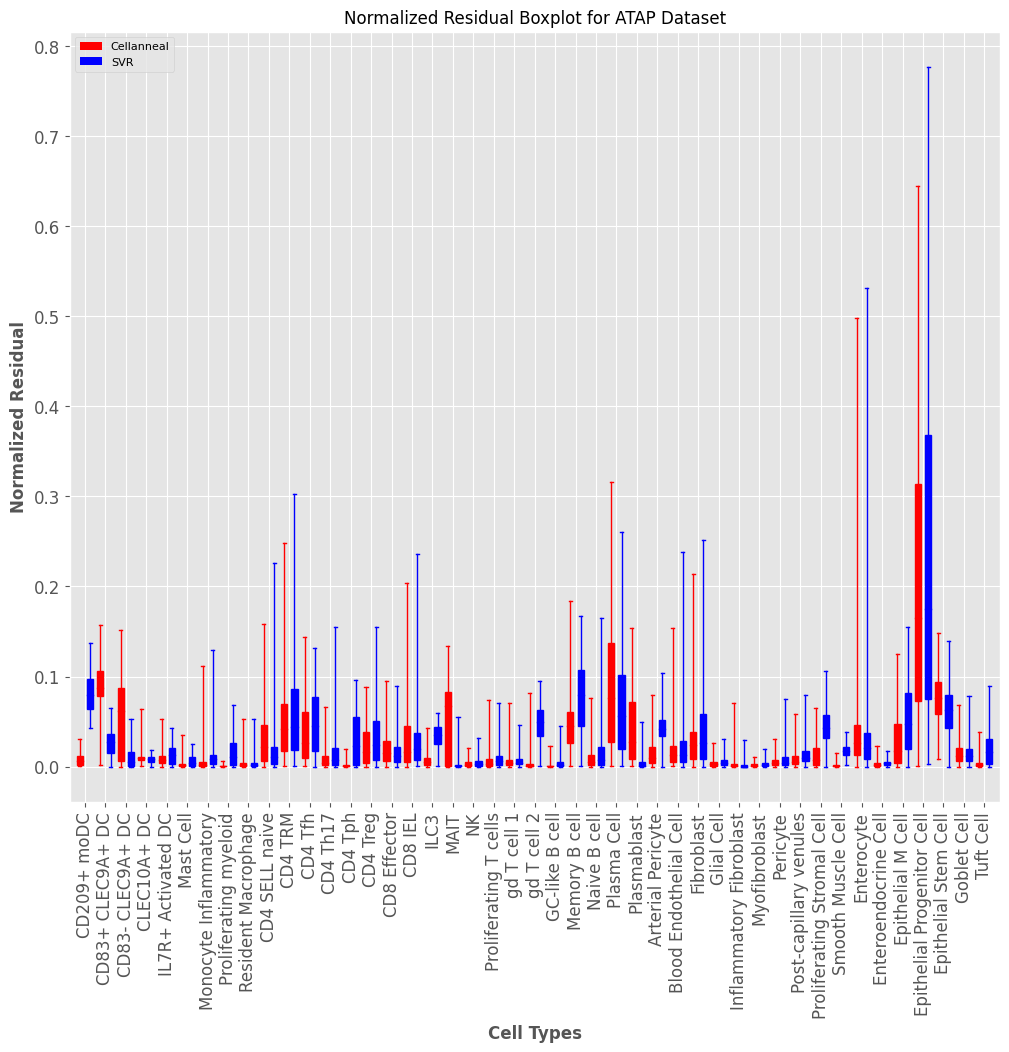

In [18]:
plot_object.nresidual(cellanneal_g,svr_g.T,atap_true)

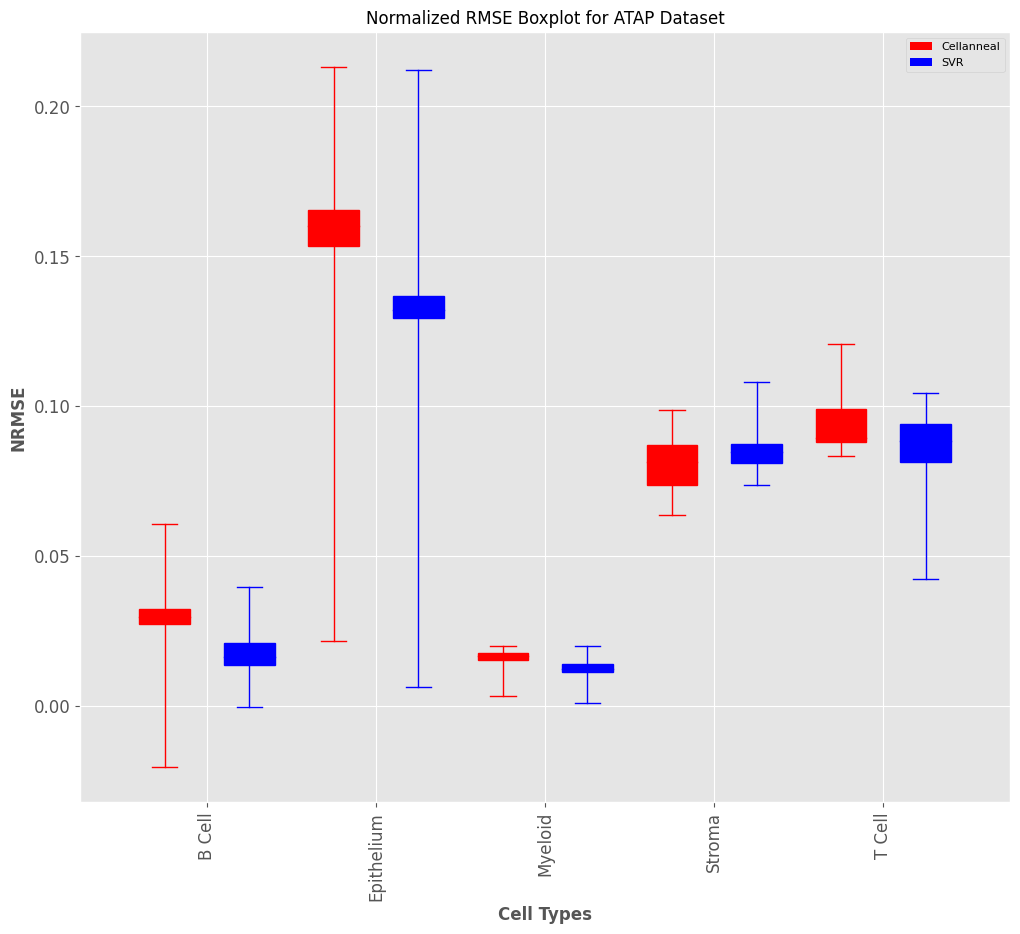

In [19]:
plot_object.nrmse(cellanneal,svr,atap_true_general)

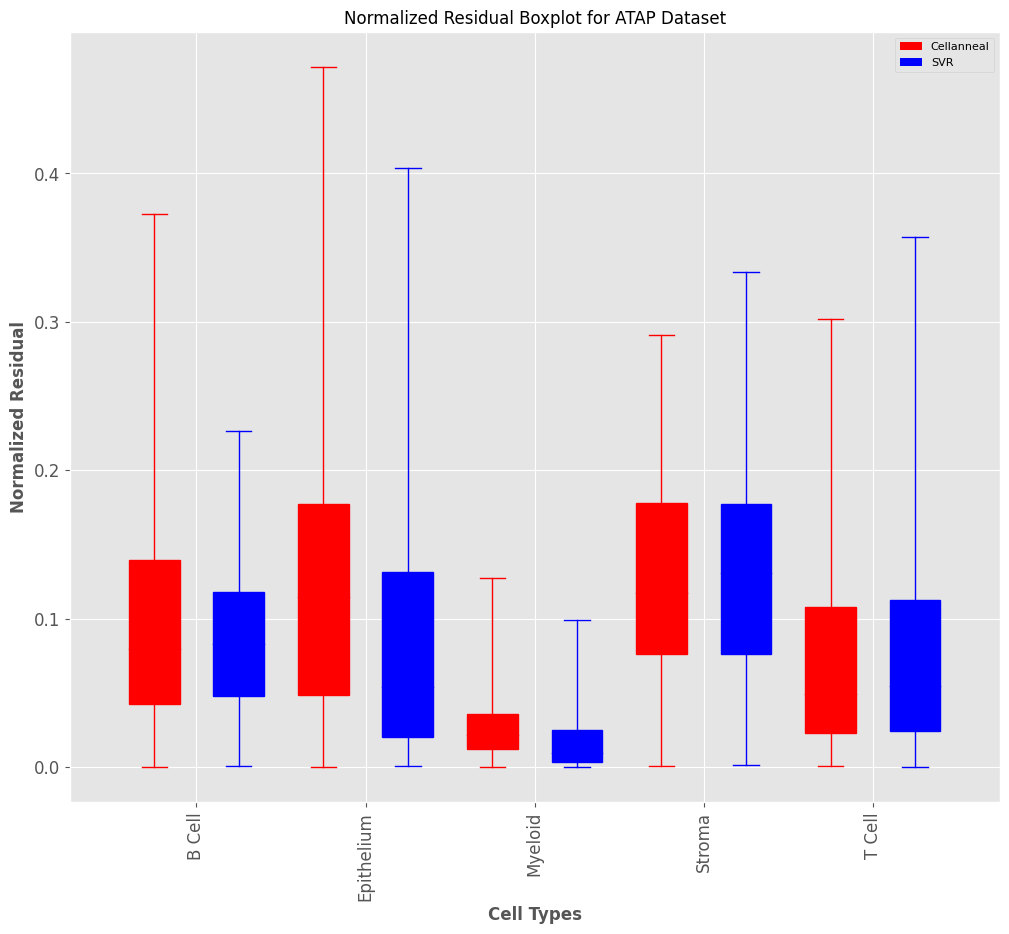

In [20]:
plot_object.nresidual(cellanneal,svr,atap_true_general)

There are a few other plotting modules and they can be found in: `/src/validation-experiment.ipynb` but are not as relevant as the ones provided in this notebook